In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
base_path = os.path.abspath(os.pardir)
sys.path.append(base_path)

from data_utils import data_reader

# Data visualization

We want to look at the full data before splitting them. In particular, check of long the average series of event pictures is.

In [2]:
# read metadata of all files to explore
if False:
    data = data_reader.read_dir_metadata(base_path + "/data/source_data/", False, True)
    data.to_hdf(base_path + "/data/source_data/metadata_raw.hdf5", "df")
else:
    data = pd.read_hdf(base_path + "/data/source_data/metadata_raw.hdf5")

(array([3.690e+02, 0.000e+00, 2.510e+02, 0.000e+00, 6.887e+03, 0.000e+00,
       5.000e+00, 0.000e+00, 1.000e+00, 1.700e+02]), array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]), <a list of 10 Patch objects>)


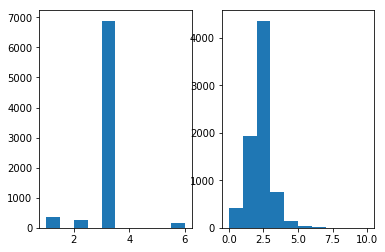

410

In [3]:
#print(data.groupby('event_key_simple').size().describe())
# plot distribution of images
plt.subplot(1, 2, 1)
hist_data = plt.hist(data.groupby('event_key_simple').size())
print(hist_data)

# how much time did the series span on average?
plt.subplot(1, 2, 2)
plt.hist((data.groupby('event_key_simple').last()['datetime'].subtract(data.groupby('event_key_simple').first()['datetime'])).dt.seconds)
plt.show()

sum(data.groupby('event_key_simple').last()['datetime'].subtract(data.groupby('event_key_simple').first()['datetime']).dt.seconds == 0)

Most of the events consist of **3** shots, the rest are some outliers of 1,2 or 6 pictures. However, some of the 6 picture series seem to be duplicates.

The reader function marked duplicates, distinguishing between normal duplicates and duplicates with conflicting labels. If we plot them, the events with more images are gone.

(array([ 369.,    0.,    0.,    0.,    0.,  242.,    0.,    0.,    0.,
       6887.]), array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]), <a list of 10 Patch objects>)


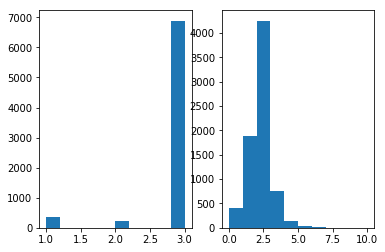

In [4]:
non_dup_data = data[data.duplicates==0]

plt.subplot(1, 2, 1)
hist_data = plt.hist(non_dup_data.groupby('event_key_simple').size())
print(hist_data)

plt.subplot(1, 2, 2)
plt.hist((non_dup_data.groupby('event_key_simple').last()['datetime'].subtract(non_dup_data.groupby('event_key_simple').first()['datetime'])).dt.seconds)
plt.show()

# Data split

We split the image data into training and validation sets. Later we can extract the necessary metadata from the training set to train the network.  
Need to be careful to maintain series of events while shuffling, i.e. only shuffle whole series of events.

To maintain a balance of images, the default validation fraction of 0.1 could be weighted by image series length. But since most series are 3 images long, we just split the image series.

We could also split on the extended events, to be determined if it makes sense.

In [5]:
def split_simple(data, train_dir, val_dir, val_frac):
    # assign files to train/val independently
    # but still no duplicates or mislabeled examples
    was_added = set()
    for index, row in data.iterrows():
        # skip items with conflicting labels
        if row['duplicate'] == 2:
            continue

        # only ever add one item that's duplicated
        if row['duplicate'] == 1:
            # if already added, continue
            if row['event_key_simple'] in was_added:
                continue

            # remember we added it
            was_added.add(row['event_key_simple'])

        is_validation = (random.random() < val_frac)
        target_dir = val_dir if is_validation else train_dir
        target_label = 'val' if is_validation else 'train'

        (src_file, dst_file) = (row['path'], target_dir + '/' + row['filename'])
        os.symlink(src_file, dst_file)
        #print("{} --> {}".format(src_file, dst_file))
        
        
# move the files in the group_data to their output directory
# additionally add a metadata label for the set the files are moved to
def move_file_group(data, group_data, target_dir, target_label, check_added = False): 
    was_added = set()
    for index, row in group_data.iterrows():
        if check_added:
            if row['sequence_idx'] in was_added: continue
            was_added.add(row['sequence_idx'])
        
        # move the file to its directory
        (src_file, dst_file) = (row['path'], target_dir + '/' + row['label'] + '/' + row['label'] + '_' + str(index) + '.jpg')
        #print("{} --> {}".format(src_file, dst_file))
        #shutil.copy(src_file, dst_file)
        os.symlink(src_file, dst_file)
        
        # mark the set the file is moved to in the metadata
        data.loc[index, 'set'] = target_label
        data.loc[index, 'set_path'] = dst_file
        
        
def split_events(data, train_dir, val_dir, val_frac):
    # first, split non-duplicated simple events
    for group in data[data.duplicates == 0].groupby('event_key_simple'):
        is_validation = (random.random() < val_frac)
        target_dir = val_dir if is_validation else train_dir
        target_label = 'val' if is_validation else 'train'
        move_file_group(data, group[1], target_dir, target_label)

    # split duplicated events with same labels, but only move one set of images
    for group in data[data.duplicates == 1].groupby(['event_key_simple']):
        #dedup_group = group[1].groupby('sequence_idx').last()

        is_validation = (random.random() < val_frac)
        target_dir = val_dir if is_validation else train_dir
        target_label = 'val' if is_validation else 'train'
        move_file_group(data, group[1], target_dir, target_label, check_added=True)
        
        
def split_files(data, output_dir, val_frac, keep_events = True):   
    def make_set_dir(dir_name):
        os.makedirs(dir_name)
        os.makedirs(dir_name + '/cheetah')
        os.makedirs(dir_name + '/leopard')
        os.makedirs(dir_name + '/unknown')
    
    train_dir = output_dir + '/train'
    val_dir = output_dir + '/val'

    # create required directories
    if os.listdir(output_dir) != []:
        print("Error: Make sure the output directory is empty!")
        return

    print(train_dir)
    print(val_dir)

    make_set_dir(train_dir)
    make_set_dir(val_dir)
    
    random.seed(a=42)
    
    if keep_events:
        split_events(data, train_dir, val_dir, val_frac)
    else:
        split_simple(data, train_dir, val_dir, val_frac)
    
    data.to_hdf(output_dir + '/metadata.hdf5', "df")

In [ ]:
split_files(data, base_path + '/data/model_data', 0.1)

In [ ]:
print("Training: {}\t Validation: {}".format(sum(data.set=='train'), sum(data.set=='val')))
sum(data.duplicates==2)